# Contents

# 1.Loading the data

We’ll attempt to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on. The dataset has relatively few data points: only 506, split
between 404 training samples and 102 test samples. And each feature in the input data
(for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [2]:
from keras.datasets import boston_housing

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 10us/step


In [4]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

As we can see, we have 404 training samples and 102 test samples, each with 13
numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on.
The targets are the median values of owner-occupied homes, in thousands of
dollars:

In [8]:
test_targets

array([ 7.2, 18.8, 19. , 27. , 22.2, 24.5, 31.2, 22.9, 20.5, 23.2, 18.6,
       14.5, 17.8, 50. , 20.8, 24.3, 24.2, 19.8, 19.1, 22.7, 12. , 10.2,
       20. , 18.5, 20.9, 23. , 27.5, 30.1,  9.5, 22. , 21.2, 14.1, 33.1,
       23.4, 20.1,  7.4, 15.4, 23.8, 20.1, 24.5, 33. , 28.4, 14.1, 46.7,
       32.5, 29.6, 28.4, 19.8, 20.2, 25. , 35.4, 20.3,  9.7, 14.5, 34.9,
       26.6,  7.2, 50. , 32.4, 21.6, 29.8, 13.1, 27.5, 21.2, 23.1, 21.9,
       13. , 23.2,  8.1,  5.6, 21.7, 29.6, 19.6,  7. , 26.4, 18.9, 20.9,
       28.1, 35.4, 10.2, 24.3, 43.1, 17.6, 15.4, 16.2, 27.1, 21.4, 21.5,
       22.4, 25. , 16.6, 18.6, 22. , 42.8, 35.1, 21.5, 36. , 21.9, 24.1,
       50. , 26.7, 25. ])

# 2.Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult.
Let's do a feature-wise normalization also called feature scaling

In [9]:
mean = train_data.mean(axis = 0)
train_data = train_data - mean

std = train_data.std(axis = 0)
train_data = train_data / std

In [10]:
test_data -= mean
test_data /= std

# 3. Building the network

In [11]:
from keras import models, layers

## 3.1 The model definition

In [12]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


The network ends with a single unit and **no activation (it will be a linear layer)**. This is
a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer,
the network could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

## 3.2 Validating our approach using K-fold validation

**K-fold Validation **

In [13]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [15]:
for i in range(k):
    print('processing fold #', i)
    
    #Prepare the validation data for partition k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    #Prepare the training data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    #Build Keras model already compiled
    model = build_model()
    
    #Train the model in silent mode(verbose = 0)    
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
        
    #Evaluate the data on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
print('All scores\n')
print(all_scores)

All scores

[2.1146360529531347, 2.2206656248262613, 2.914611273472852, 2.3334460299794038]


In [17]:
np.mean(all_scores)

2.395839745307913

The different runs do indeed show rather different validation scores, from 2.11 to 2.91.
The average (2.4) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, we’re off by \$2,400 on average,
which is significant considering that the prices range from \$10,000 to \$50,000.
Let’s try training the network a bit longer: 500 epochs. To keep a record of how
well the model does at each epoch, we’ll modify the training loop to save the per epoch validation score log

In [18]:
num_epochs = 500
all_mae_history = []

for i in range(k):
    print('processing fold #', i)
    
    #Prepare the validation data for partition k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    #Prepare the training data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    #Build Keras model already compiled
    model = build_model()
    
    #Train the model in silent mode(verbose = 0)    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),epochs=num_epochs, batch_size=1, verbose=0)
        
    #Store the mae after each epoch
    mae_history = history.history['val_mean_absolute_error']
    all_mae_history.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


**Building the history of successive mean K-fold validation scores**

In [19]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

## 3.3 Plotting Validation Score

In [20]:
%matplotlib inline

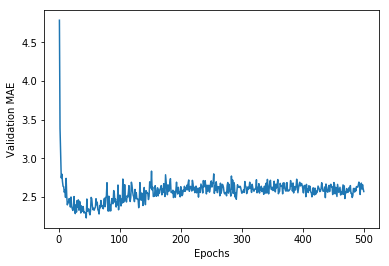

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs.
Past that point, you start overfitting.
Once we’re finished tuning other parameters of the model (in addition to the
number of epochs, we could also adjust the size of the hidden layers), we can train a
final production model on all of the training data, with the best parameters, and then
look at its performance on the test data.

In [26]:
len(average_mae_history)

500

# 4.Training the final model

In [27]:
model = build_model()
model.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 742us/step


In [28]:
test_mae_score

2.69066260842716

we’re still off by about \$2,690

# 5.Wrapping up

Here’s what we should take away from this example:
* Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.